# Comportamenti delle reti di stazioni

In [1]:
library(arrow)
library(tibble)
library(dplyr)
library(ggplot2)
library(sf)
library(rlang)
library(zeallot)
library(patchwork)

setwd(fs::path_abs("~/Local_Workspace/TesiMag"))

source("src/load/load.R");
source("src/load/load_utils.R");
source("src/plot/plot_helpers.R");

options(repr.plot.width = 15, repr.plot.height = 10)

cache_kwargs = list(load_cache = TRUE, verbose = TRUE)
flavor <- "qc_era5"


Caricamento pacchetto: 'arrow'


Il seguente oggetto `e mascherato da 'package:utils':

    timestamp



Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE


Caricamento pacchetto: 'rlang'


Il seguente oggetto `e mascherato da 'package:arrow':

    string



Caricamento pacchetto: 'lubridate'


Il seguente oggetto `e mascherato da 'package:arrow':

    duration


I seguenti oggetti sono mascherati da 'package:base':

    date, intersect, setdiff, union



Caricamento pacchetto: 'purrr'


I seguenti oggetti sono mascherati da 'package:rlang':

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice



Caricamento pacchetto: 'tsibble'


Il seguente oggetto `e mascherato da 'package:lubridate':

    interval


I seguenti ogg

In [2]:
# Matching/loading functions.
build_matches <- function(db1, db2) {
    st_join(
        db1,
        db2, st_is_within_distance,
        dist = units::set_units(10, "m"), suffix = c(".x", ".y"), left = FALSE
    ) |> st_drop_geometry()
}

to_series <- function(metadata_matches, series1, series2, tvar) {
    # Transform a dataframe of matches into a dataframe of series
    ids1 <- metadata_matches |>
        pull(identifier.x) |>
        unique()
    series1 <- series1 |>
        as_tibble() |>
        drop_na() |>
        filter(identifier %in% ids1) |>
        rename(T = {{ tvar }})

    ids2 <- metadata_matches |>
        pull(identifier.y) |>
        unique()
    series2 <- series2 |>
        as_tibble() |>
        drop_na() |>
        filter(identifier %in% ids2) |>
        rename(T = {{ tvar }})

    series1 |>
        left_join(
            metadata_matches,
            join_by(identifier == identifier.x),
            # Ci sono casi in cui più stazioni SCIA sono associate alla stessa stazione DPC e viceversa, per esempio quando una stazione viene spostata.
            relationship = "many-to-many"
        ) |>
        inner_join(
            series2,
            join_by(identifier.y == identifier, date),
            relationship = "many-to-one"
        )
}

diff_series <- function(db1, db2, series1, series2, tvar, desc = NULL) {
    matches <- build_matches(db1, db2)
    matched_series <- cached_data(
        list("JOIN", tvar),
        function(db, tvar) {
            matches |>
                to_series(series1, series2, tvar) |>
                mutate(diff = T.x - T.y)
        },
        file.path("cache", "intermediates", "series"),
        suffix = desc,
        load_cache = FALSE && cache_kwargs$load_cache && !is.null(desc)
    )
    list(metadata = matches, data = matched_series)
}

plot_hist_net <- function(data, diff_var) {
    ggplot(data = data |> filter(abs({{ diff_var }}) <= 1.05)) +
        geom_histogram(
            aes({{ diff_var }}),
            binwidth = 0.1,
            bins = 21,
            center = 0
        )
}

these_plots <- function(m.db1, m.db2, s.db1, s.db2, tvar, diff_tag, desc) {
    diffs <- diff_series(
        m.db1,
        m.db2,
        s.db1 |> filter(date >= "2010-01-01"),
        s.db2 |> filter(date >= "2010-01-01"),
        tvar,
        desc = desc
    )
    p_net <- plot_hist_net(diffs$data, diff) +
        facet_wrap(. ~ rete, ncol = 4, scales = "free_y") +
        labs(title = tvar, x = diff_tag)
    ggsave(str_glue("plots/hist_net_{diff_tag}_{tvar}.pdf"), p_net, width = 9, height = 12)
    p_state <- plot_hist_net(diffs$data, diff) +
        facet_wrap(. ~ state.x, ncol = 4, scales = "free_y") +
        labs(title = tvar, x = diff_tag)
    ggsave(str_glue("plots/hist_state_{diff_tag}_{tvar}.pdf"), p_state, width = 9, height = 18)
    list(diffs$data, p_net, p_state)
}
m.scia.tmax <- load.metadata("SCIA", "T_MAX", .cache_kwargs = cache_kwargs)
s.scia.tmax <- load.series("SCIA", "T_MAX", .cache_kwargs = cache_kwargs) |> filter(date >= as.Date("2010-01-01"))
m.scia.tmin <- load.metadata("SCIA", "T_MIN", .cache_kwargs = cache_kwargs)
s.scia.tmin <- load.series("SCIA", "T_MIN", .cache_kwargs = cache_kwargs) |> filter(date >= as.Date("2010-01-01"))
gc()

Cache found: SCIA/T_MAX, suffix: <>, loading from disk

Cache found: SCIA/T_MAX, suffix: <>, loading from disk

Cache found: SCIA/T_MIN, suffix: <>, loading from disk

Cache found: SCIA/T_MIN, suffix: <>, loading from disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1446707,77.3,2194934,117.3,NA,2194934,117.3
Vcells,54727430,417.6,303668467,2316.9,16384,355464626,2712.0


## $\Delta \mathrm{T_{MAX}}$ SCIA-DPC

Cache found: DPC/T_MAX/qc_homo, suffix: <>, loading from disk

Cache not found: JOIN/T_MAX, suffix: <_SCIA-DPC_2010>

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(tvar)

  # Now:
  data %>% select(all_of(tvar))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
Cache found: DPC/T_MAX/qc_homo, suffix: <>, loading from disk

Saving to disk



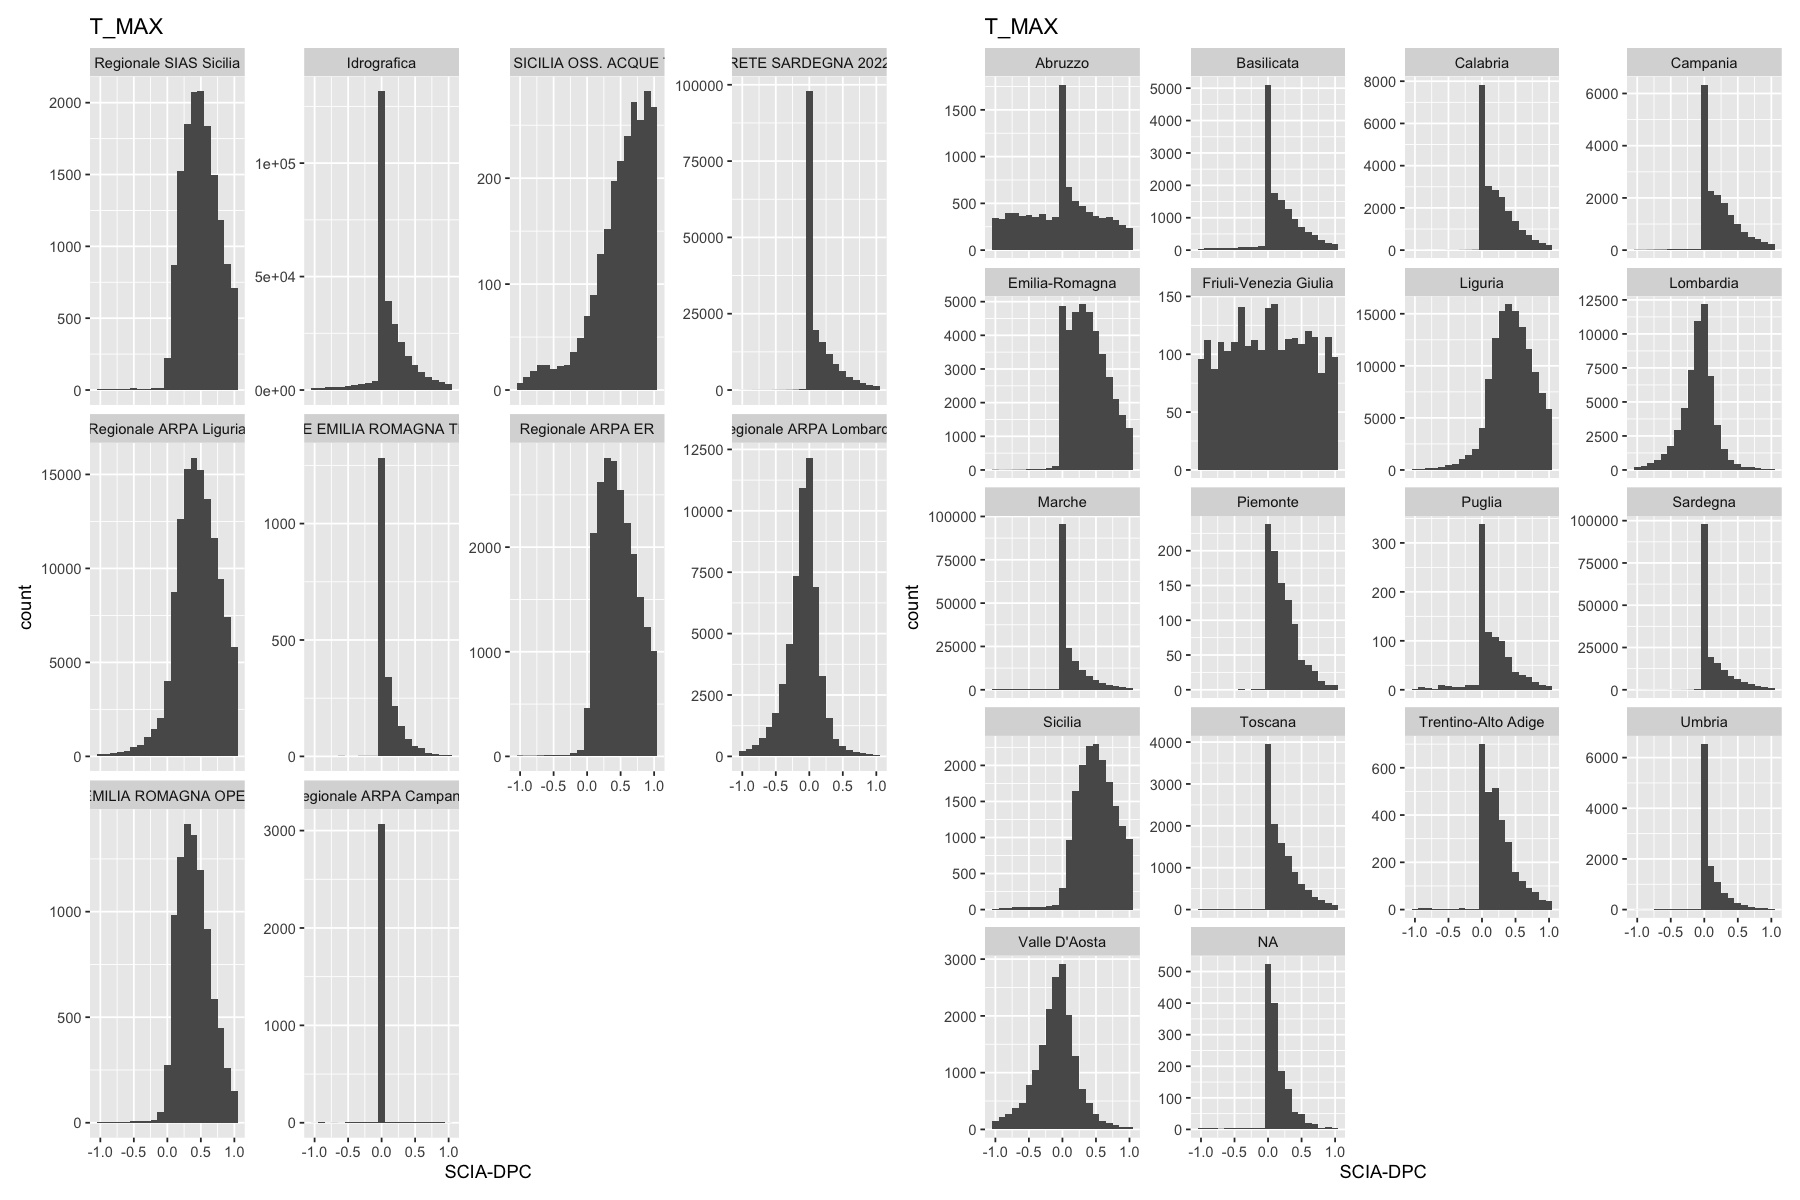

In [3]:
tvar <- "T_MAX"

c(d.tmax, p_net, p_state) %<-% these_plots(
    m.scia.tmax,
    load.metadata("DPC", tvar, flavor, .cache_kwargs = cache_kwargs),
    s.scia.tmax,
    load.series("DPC", tvar, flavor, .cache_kwargs = cache_kwargs) |> filter(date > as.Date("2010-01-01")),
    tvar,
    "SCIA-DPC",
    "_SCIA-DPC_2010"
)
p_net + p_state

## $\Delta \mathrm{T_{MIN}}$ SCIA-DPC

Cache found: DPC/T_MIN/qc_homo, suffix: <>, loading from disk

Cache not found: JOIN/T_MIN, suffix: <_SCIA-DPC_2010>

Cache found: DPC/T_MIN/qc_homo, suffix: <>, loading from disk

Saving to disk



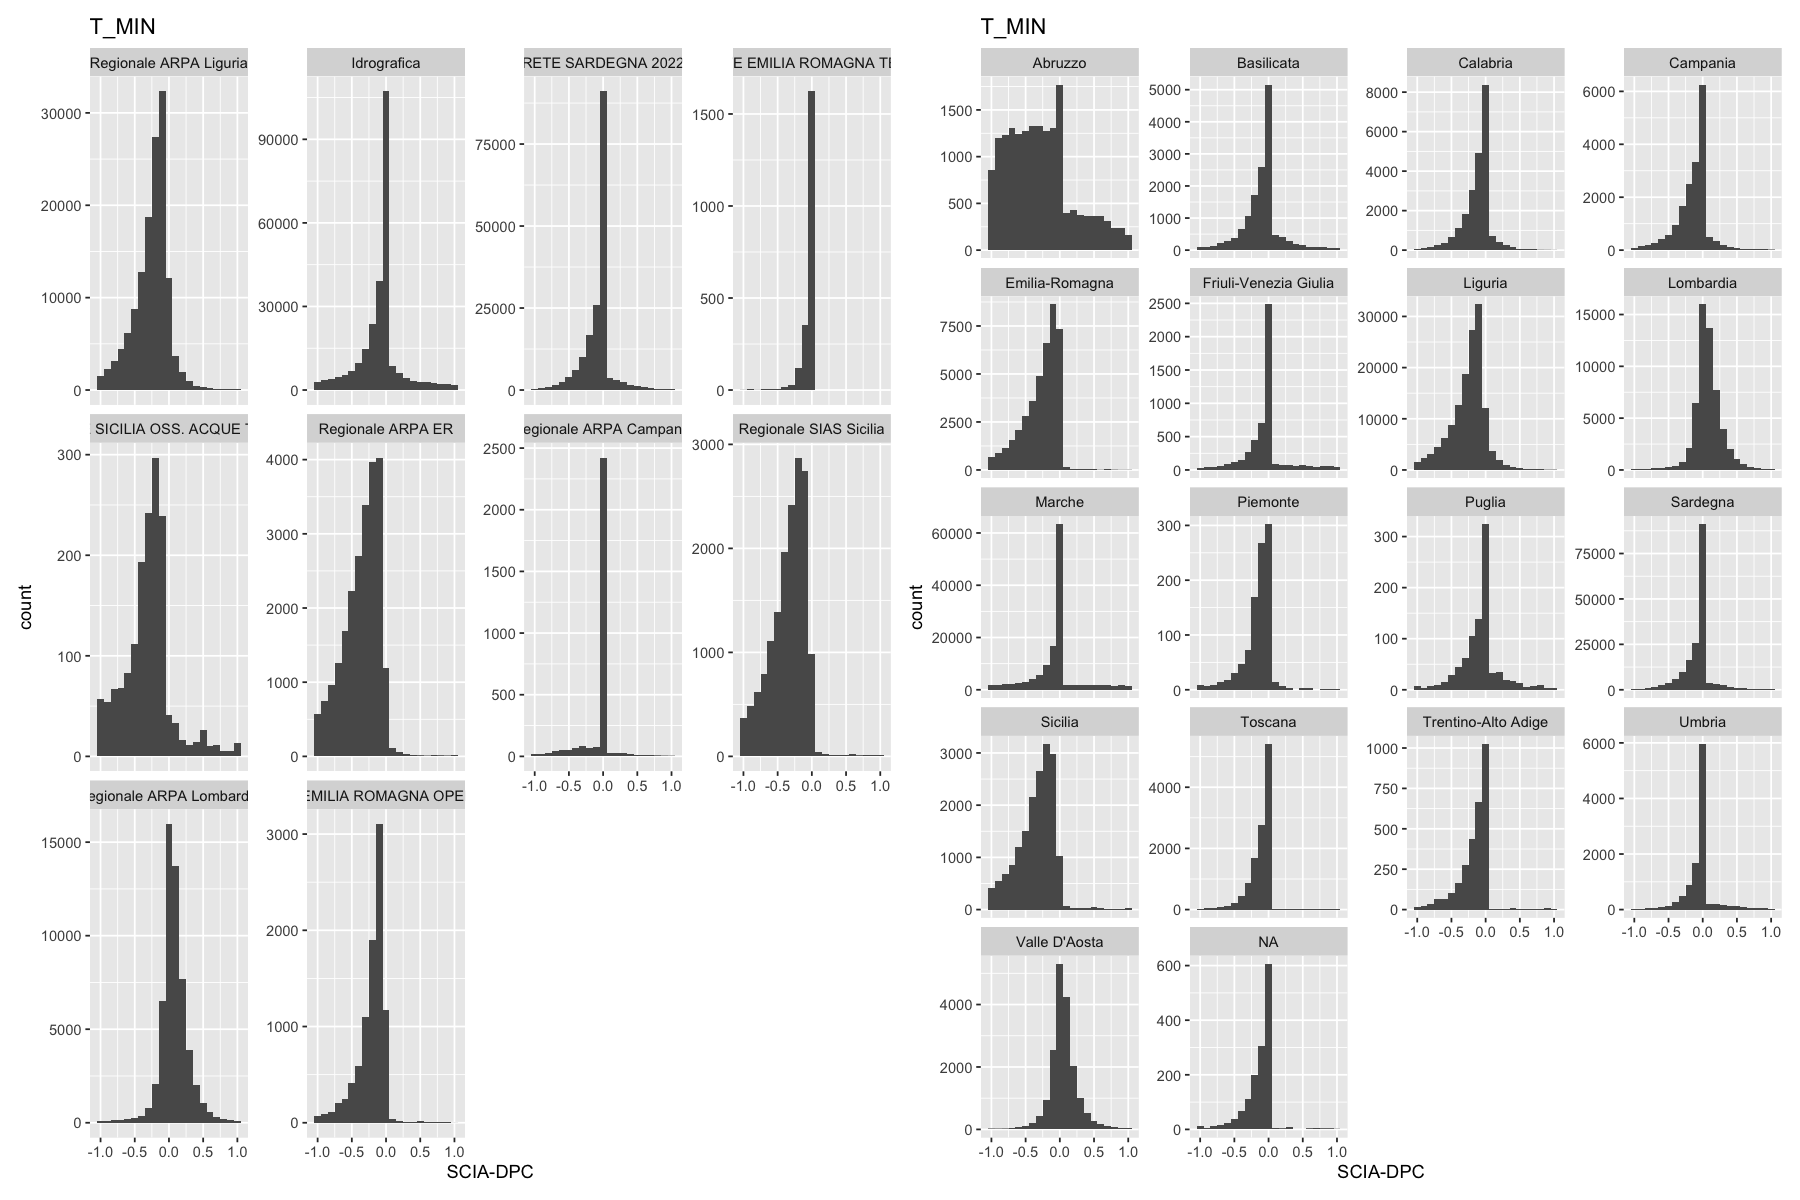

In [4]:
tvar <- "T_MIN"

c(d.tmin, p_net, p_state) %<-% these_plots(
    m.scia.tmin,
    load.metadata("DPC", tvar, flavor, .cache_kwargs = cache_kwargs),
    s.scia.tmin,
    load.series("DPC", tvar, flavor, .cache_kwargs = cache_kwargs) |> filter(date > as.Date("2010-01-01")),
    tvar,
    "SCIA-DPC",
    "_SCIA-DPC_2010"
)
p_net + p_state

Osservazioni:
- il trend per tutte le stazioni è compatibile con l'ipotesi che SCIA faccia statistiche su dati "grezzi" mentre DPC su medie orarie;
- per alcune reti il trend si presenta in maniera "assoluta" (nessuna eccezione), per altre no;
- Lombardia e Liguria seguono meno il trend;
- alcune reti hanno bias netti: Meteo Trentino, ER OpenData, SIAS Sicilia ad esempio hanno massimo nelle differenze su valori != 0.

## $\Delta \mathrm{T}$

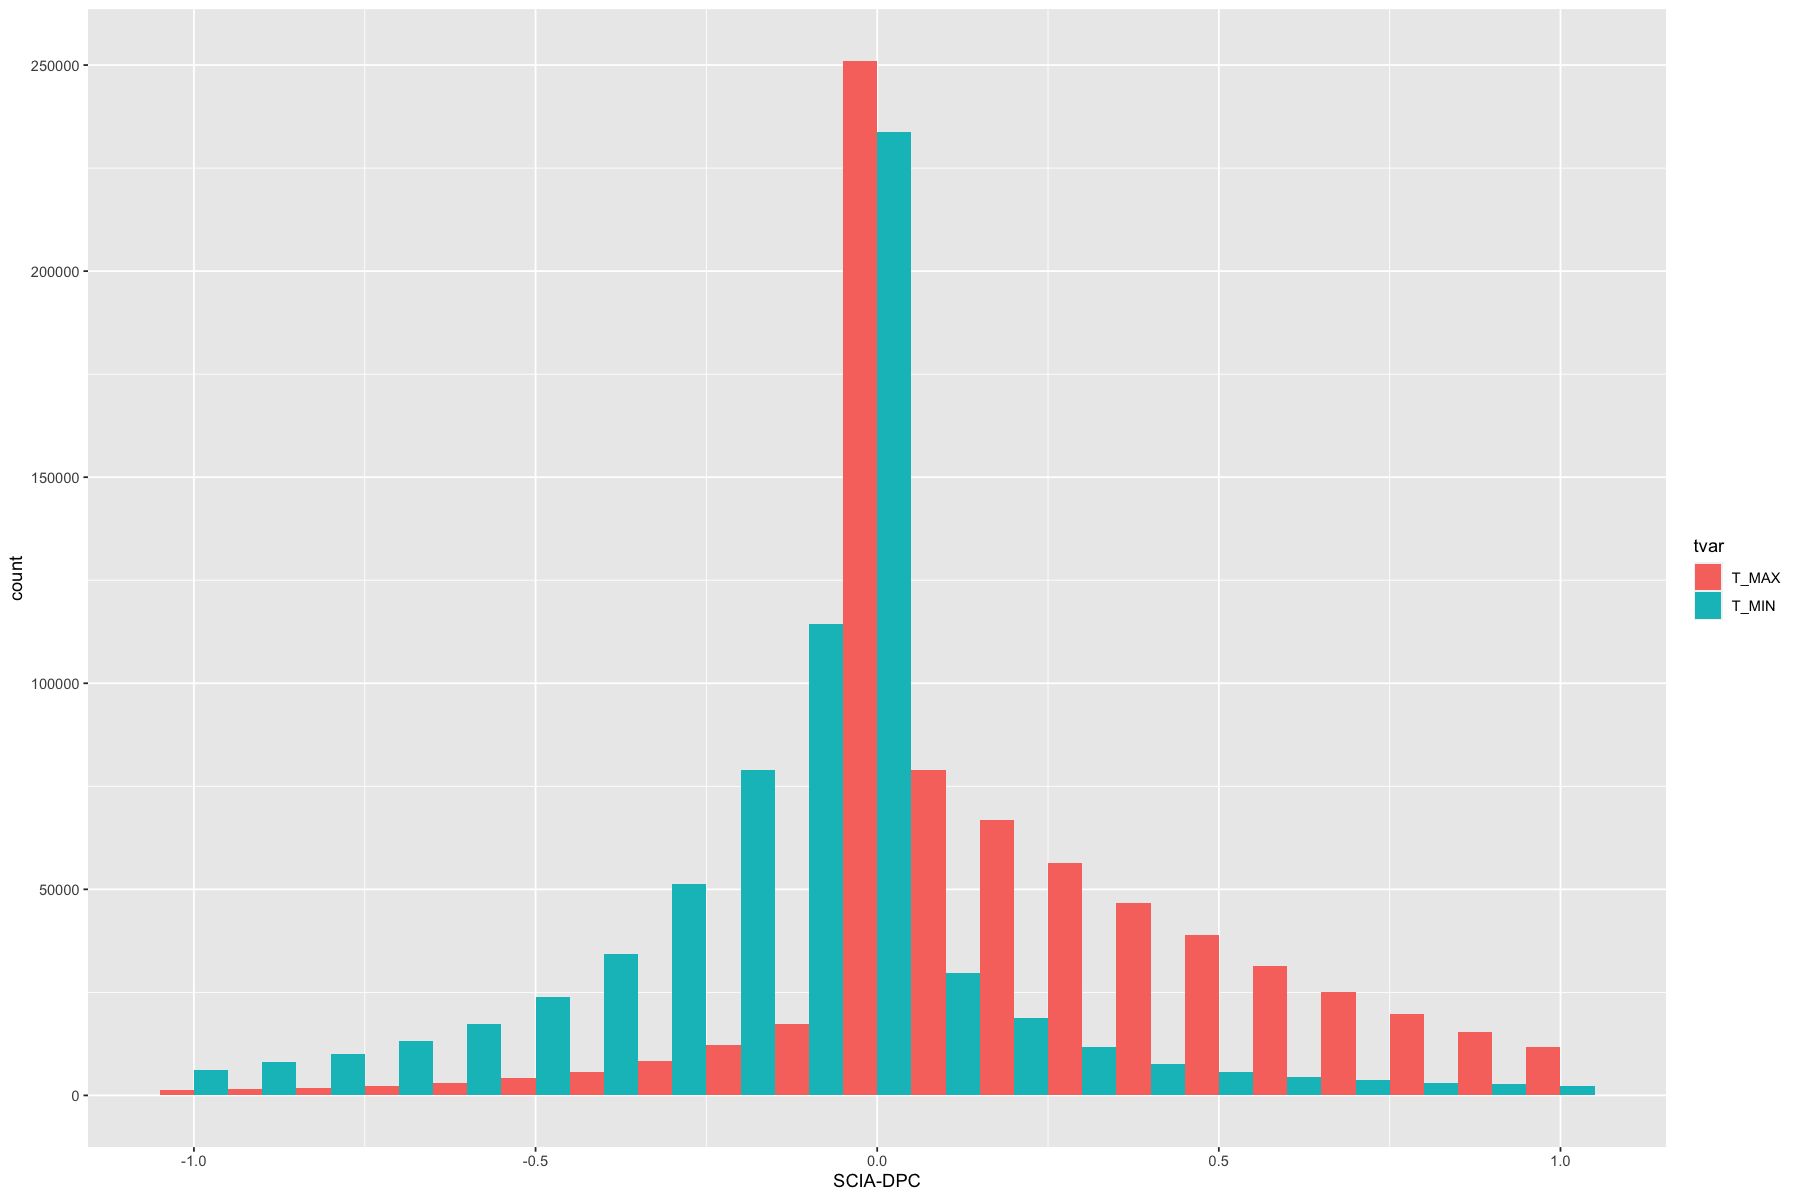

In [5]:
data <- bind_rows(
    T_MAX = d.tmax |> select(diff, elevation.x),
    T_MIN = d.tmin |> select(diff, elevation.x),
    .id = "tvar"
)
ggplot(data = data |> filter(abs(diff) <= 1.05)) +
    geom_histogram(
        aes(diff, fill = tvar),
        bins = 21,
        binwidth = 0.1,
        center = 0,
        position = "dodge",
    ) +
    labs(x = "SCIA-DPC")
ggsave(str_glue("plots/hist_net_both.pdf"), width = 12, height = 12)

## $\Delta \mathrm{T_{MAX}}$ SCIA-NODPC

Cache found: BRUN/T_MAX/qc_homo, suffix: <>, loading from disk

Cache found: DPC/T_MAX/qc_homo, suffix: <>, loading from disk

Cache existed but was not loaded: BRUN/T_MAX/qc_homo, suffix: <>

Cache not found: JOIN/T_MAX, suffix: <_SCIA-NODPC_2010>

Saving to disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2029724,108.4,4696215,250.9,NA,4696215,250.9
Vcells,112741991,860.2,426510907,3254.1,16384,533125360,4067.5


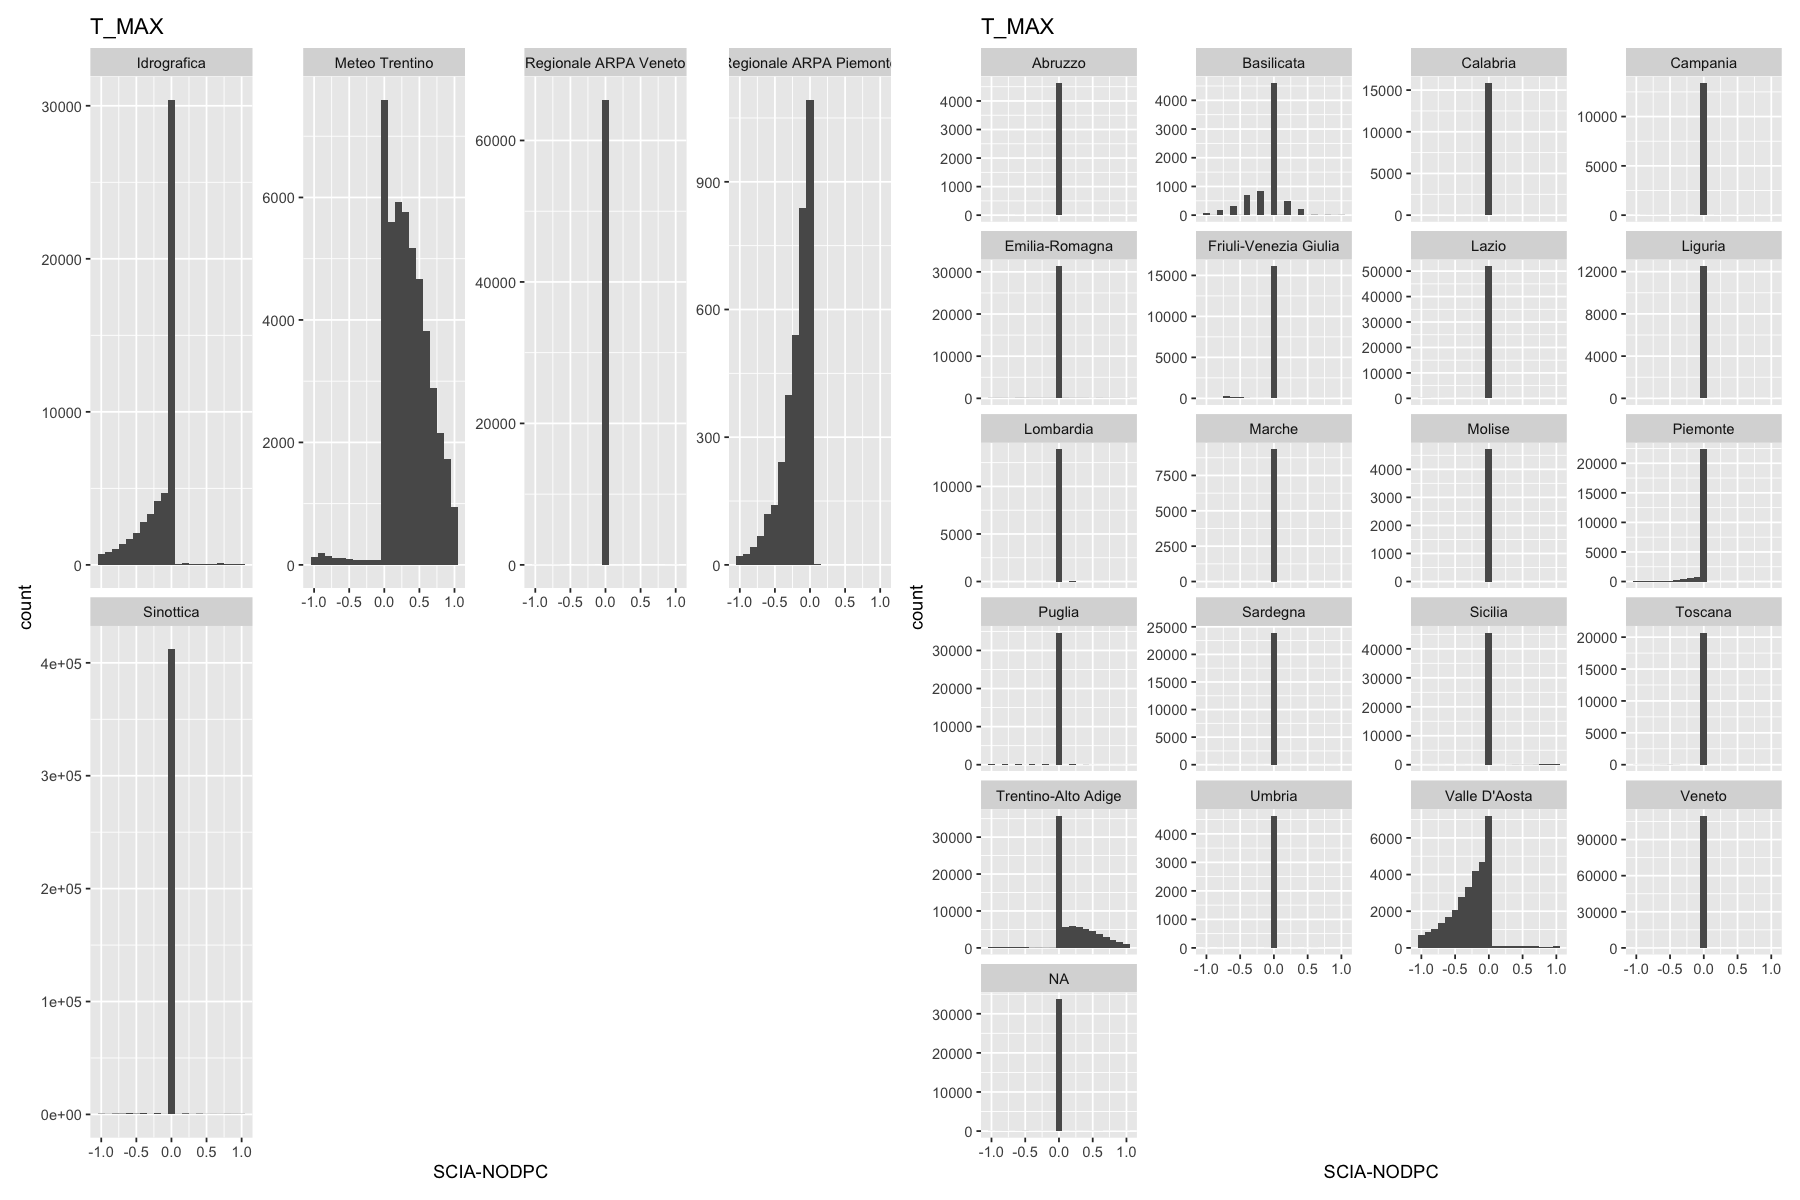

In [6]:
tvar <- "T_MAX"

m.brun <- load.metadata("BRUN", tvar, flavor, .cache_kwargs = cache_kwargs)
m.dpc <- load.metadata("DPC", tvar, flavor, .cache_kwargs = cache_kwargs)
m.nodpc <- anti_join(m.brun, m.dpc |> st_drop_geometry(), by = "identifier")
s.nodpc <- load.series("BRUN", tvar, flavor, .cache_kwargs = list(load_cache = FALSE, verbose = TRUE)) |> filter(identifier %in% m.nodpc$identifier, date > as.Date("2010-01-01"))
c(d.tmax, p_net, p_state) %<-% these_plots(
    m.scia.tmax,
    m.nodpc,
    s.scia.tmax,
    s.nodpc,
    tvar,
    "SCIA-NODPC",
    "_SCIA-NODPC_2010"
)
p_net + p_state
gc()


## $\Delta \mathrm{T_{MIN}}$ SCIA-NODPC

Cache found: BRUN/T_MIN/qc_homo, suffix: <>, loading from disk

Cache found: DPC/T_MIN/qc_homo, suffix: <>, loading from disk

Cache existed but was not loaded: BRUN/T_MIN/qc_homo, suffix: <>

Cache not found: JOIN/T_MIN, suffix: <_SCIA-NODPC_2010>

Saving to disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2030591,108.5,4696215,250.9,NA,4696215,250.9
Vcells,112801694,860.7,333275643,2542.7,16384,533125360,4067.5


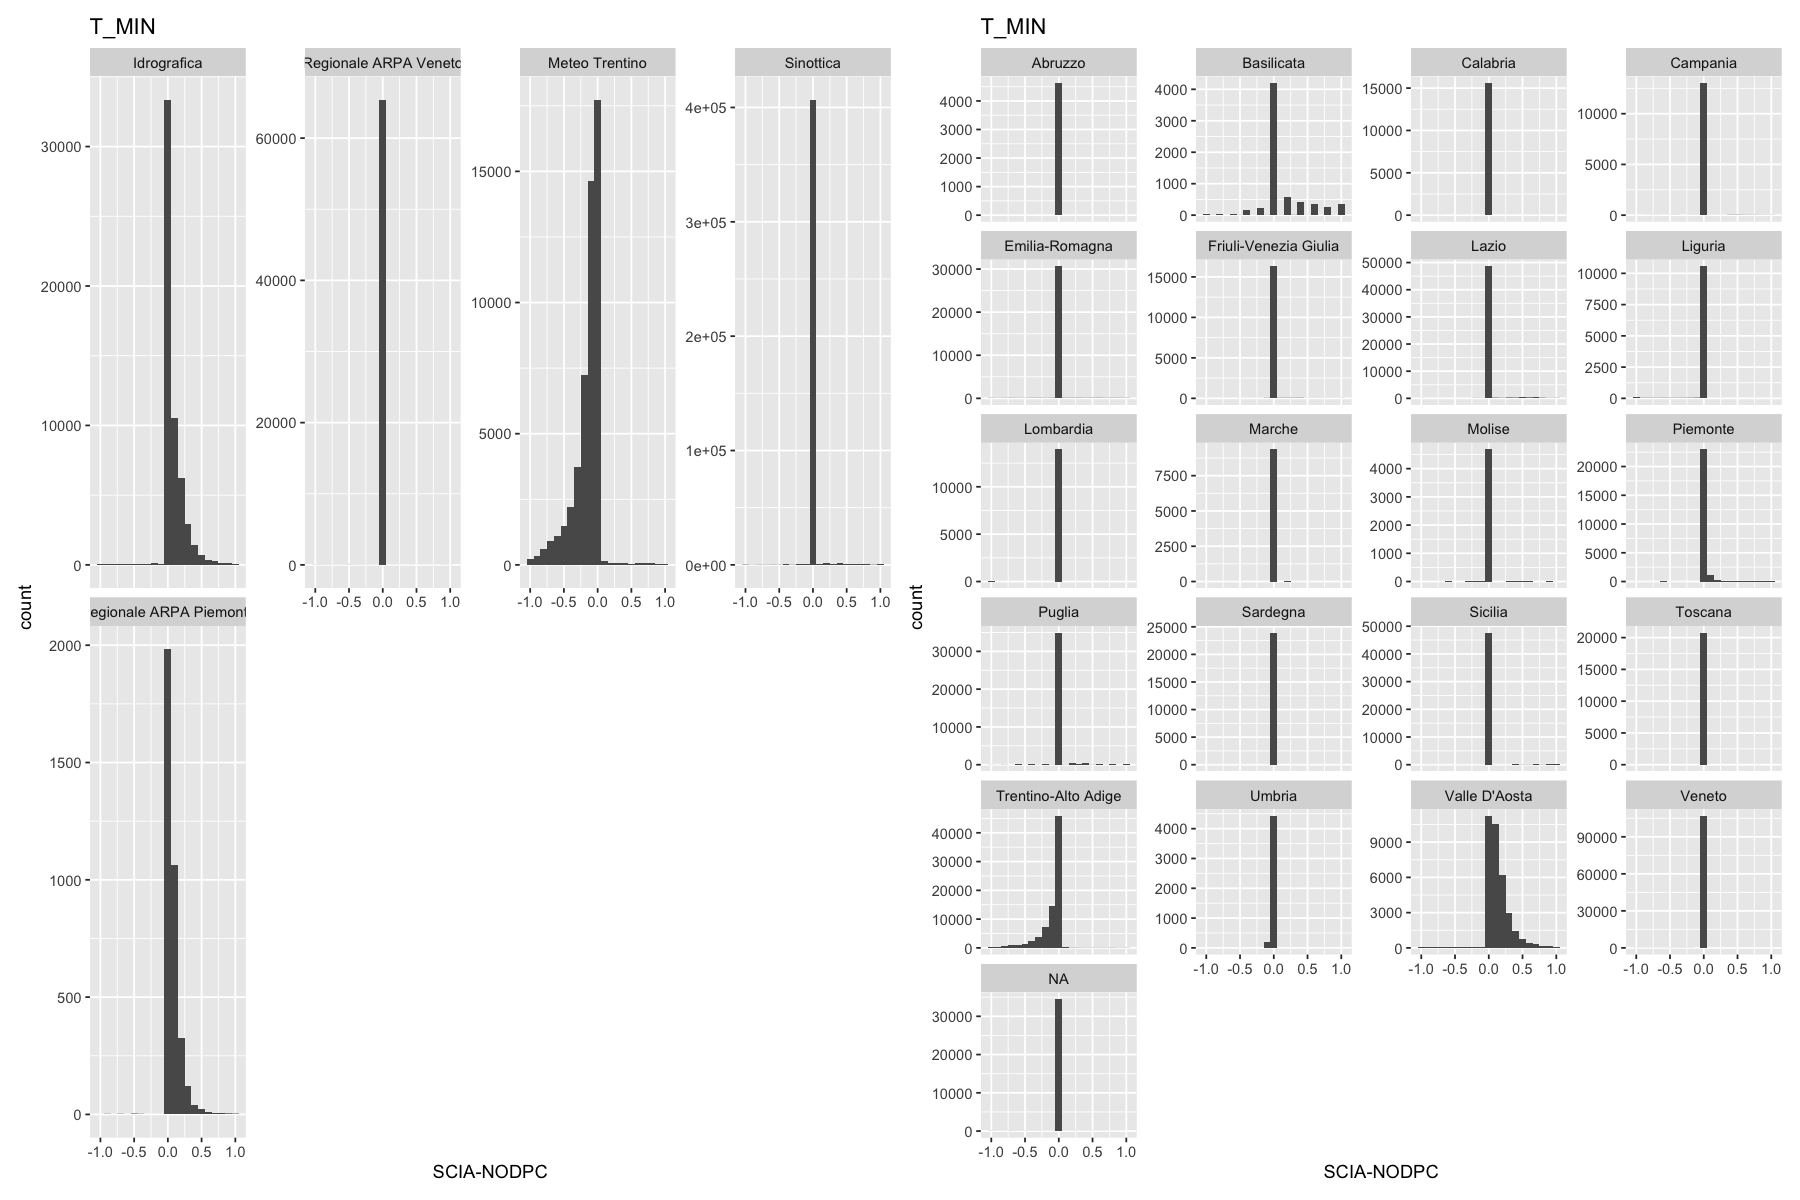

In [7]:
tvar <- "T_MIN"

m.brun <- load.metadata("BRUN", tvar, flavor, .cache_kwargs = cache_kwargs)
m.dpc <- load.metadata("DPC", tvar, flavor, .cache_kwargs = cache_kwargs)
m.nodpc <- anti_join(m.brun, m.dpc |> st_drop_geometry(), by = "identifier")
s.nodpc <- load.series("BRUN", tvar, flavor, .cache_kwargs = list(load_cache = FALSE, verbose = TRUE)) |> filter(identifier %in% m.nodpc$identifier, date > as.Date("2010-01-01"))
c(d.tmax, p_net, p_state) %<-% these_plots(
    m.scia.tmin,
    m.nodpc,
    s.scia.tmin,
    s.nodpc,
    tvar,
    "SCIA-NODPC",
    "_SCIA-NODPC_2010"
)
p_net + p_state
gc()



Osservazioni:
- Sinottica (AM) comunica registrazioni orarie: come c'è da aspettarsi le differenze non sono significative (non ho la questione "estremi assoluti vs estremi delle medie orarie");
- ARPA Piemonte si comporta come le stazioni DPC (ATTENZIONE: nell'analisi DPC non ho trovato match per questa rete!); Idrografica anche;
- ARPA Veneto ha differenze non significative;
- Meteo Trentino si comporta in maniera opposta. Comunica a SCIA statistiche orarie mentre a NODPC no? La cosa strana è che per le stazioni DPC invece funziona nella maniera attesa...

## $\Delta \mathrm{T}$ SCIA-NODPC

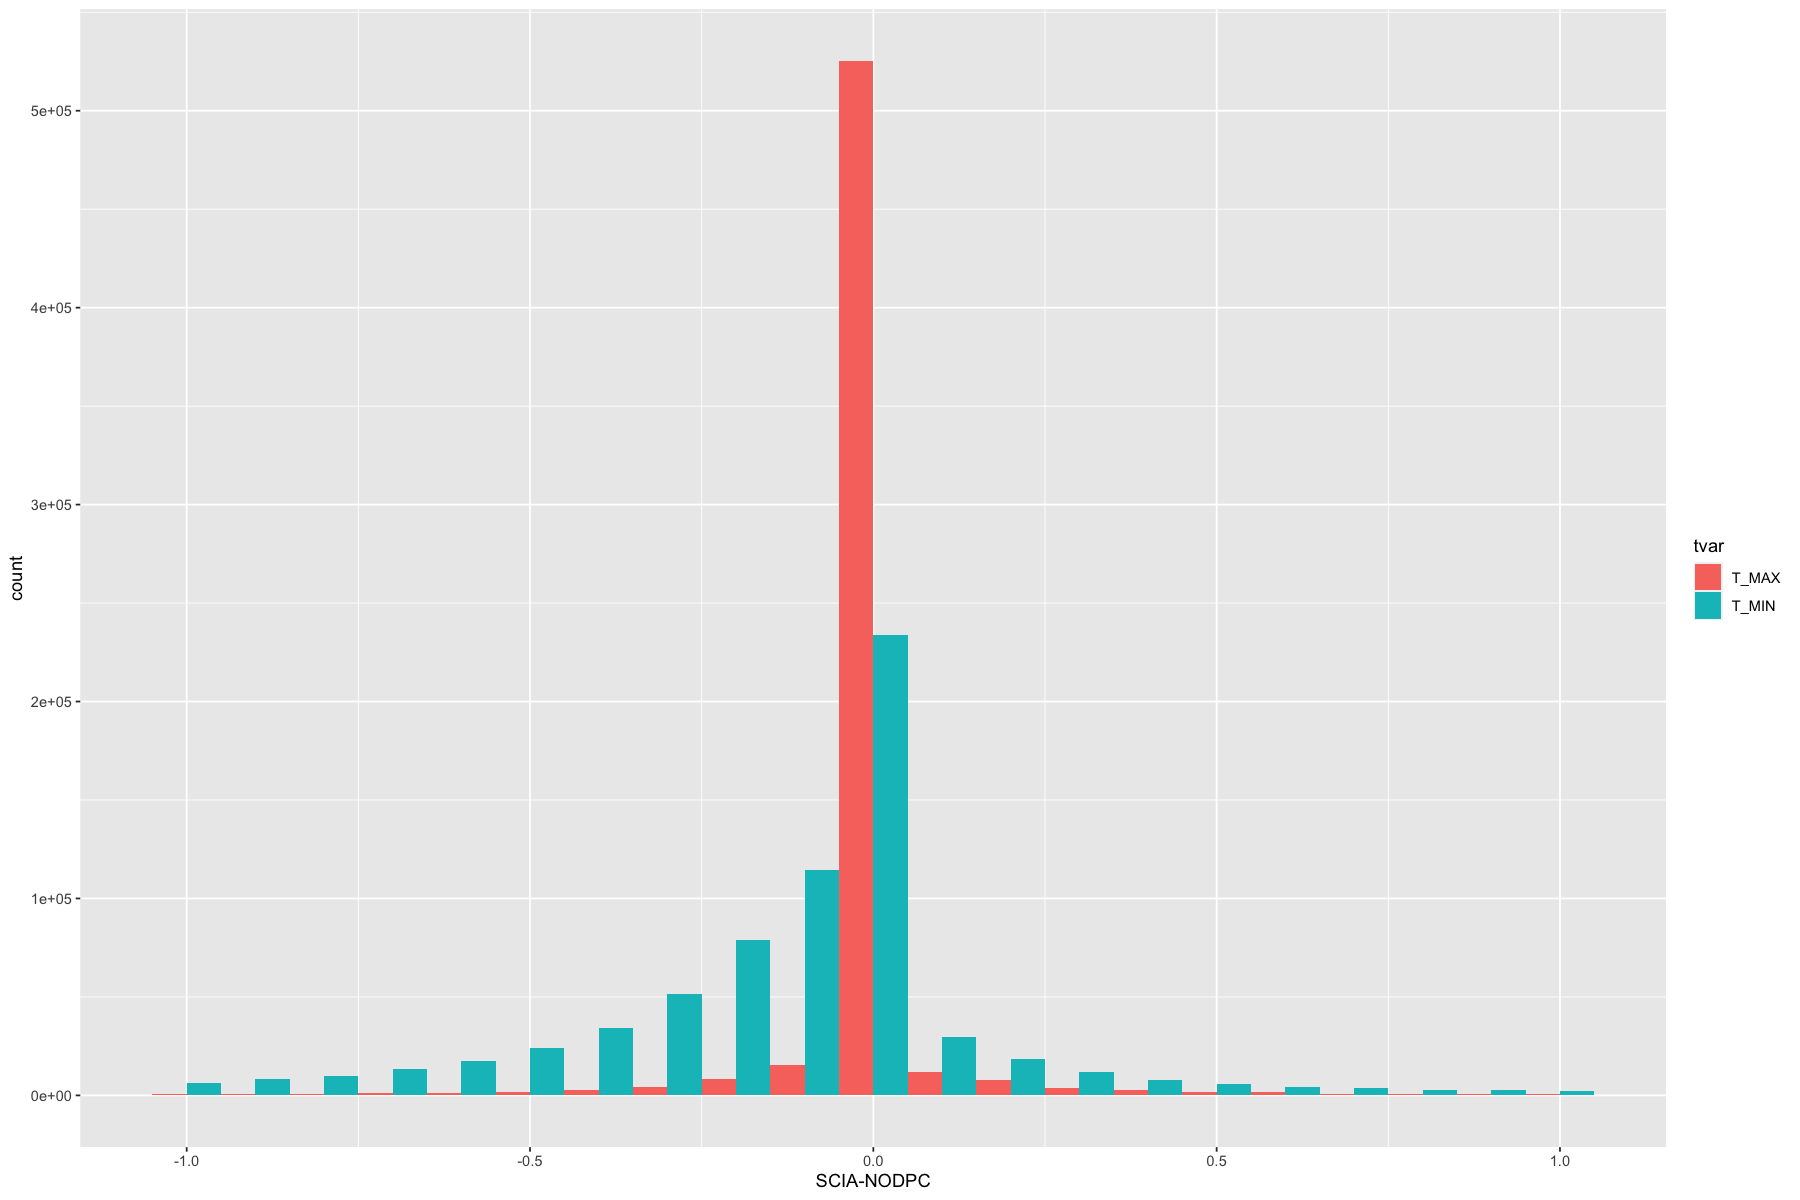

In [8]:
data <- bind_rows(
    T_MAX = d.tmax |> select(diff, elevation.x),
    T_MIN = d.tmin |> select(diff, elevation.x),
    .id = "tvar"
)
ggplot(data = data |> filter(abs(diff) <= 1.05)) +
    geom_histogram(
        aes(diff, fill = tvar),
        bins = 21,
        binwidth = 0.1,
        center = 0,
        position = "dodge",
    ) +
    labs(x = "SCIA-NODPC")
ggsave(str_glue("plots/hist_net_NODPC_both.pdf"), width = 12, height = 12)

Qualche osservazione:
- non esistono match per alcune reti, in dipendenza dall'archivio:
    - in DPC non ci sono le sinottiche;
- so che le sinottiche registrano i dati con cadenza oraria: le differenze difatti sono minime;